In [1]:
# 출처: https://yunwoong.tistory.com/73?category=902345 [윤웅의 프로그래밍 블로그]

from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np

In [2]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

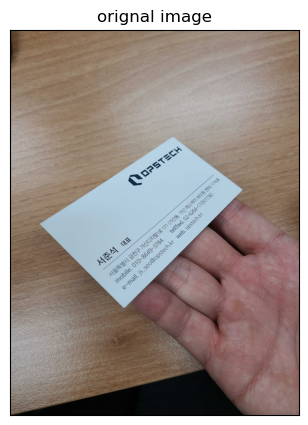

In [3]:
org_image = cv2.imread("card.jpg")
 
plt_imshow("orignal image", org_image)

In [4]:
def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []
 
  org_image = image.copy()
  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])
 
  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)
 
  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]
 
  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
  findCnt = None
 
  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break
 
  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))
 
  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)
 
  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)
 
  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)
 
  return transform_image

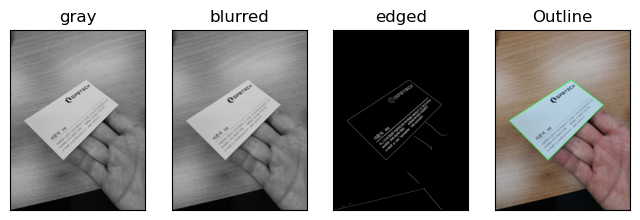

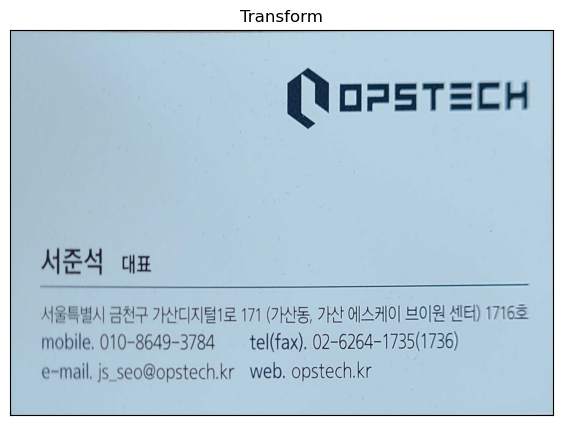

In [5]:
card_image = make_scan_image(org_image, 900, ksize=(5,5), min_threshold=75, max_threshold=200)

In [6]:
options = "--oem 3 --psm 6"
text = pytesseract.image_to_string(cv2.cvtColor(card_image, cv2.COLOR_BGR2RGB), config=options, lang='kor+eng')
 
# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")

[INFO] OCR결과:
서준석 대표

서물특별시 금천구 가산디지털1로 171 (가산동, 가산 에스케이 브이원 센터) 1716호
00016. 010-8649-3784 16130. 02-6264-1735(1736)
   e-mail, | Seo@opstech.kr web. opstech.kr





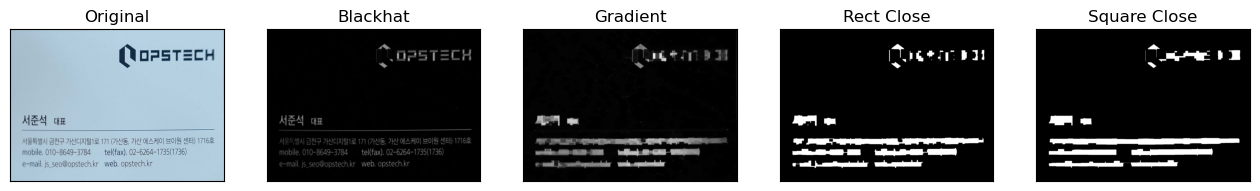

In [7]:
gray = cv2.cvtColor(card_image, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape
 
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 20))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 21))
 
gray = cv2.GaussianBlur(gray, (11, 11), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
 
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
 
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
close_thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
close_thresh = cv2.erode(close_thresh, None, iterations=2)
 
plt_imshow(["Original", "Blackhat", "Gradient", "Rect Close", "Square Close"], [card_image, blackhat, grad, thresh, close_thresh], figsize=(16, 10))

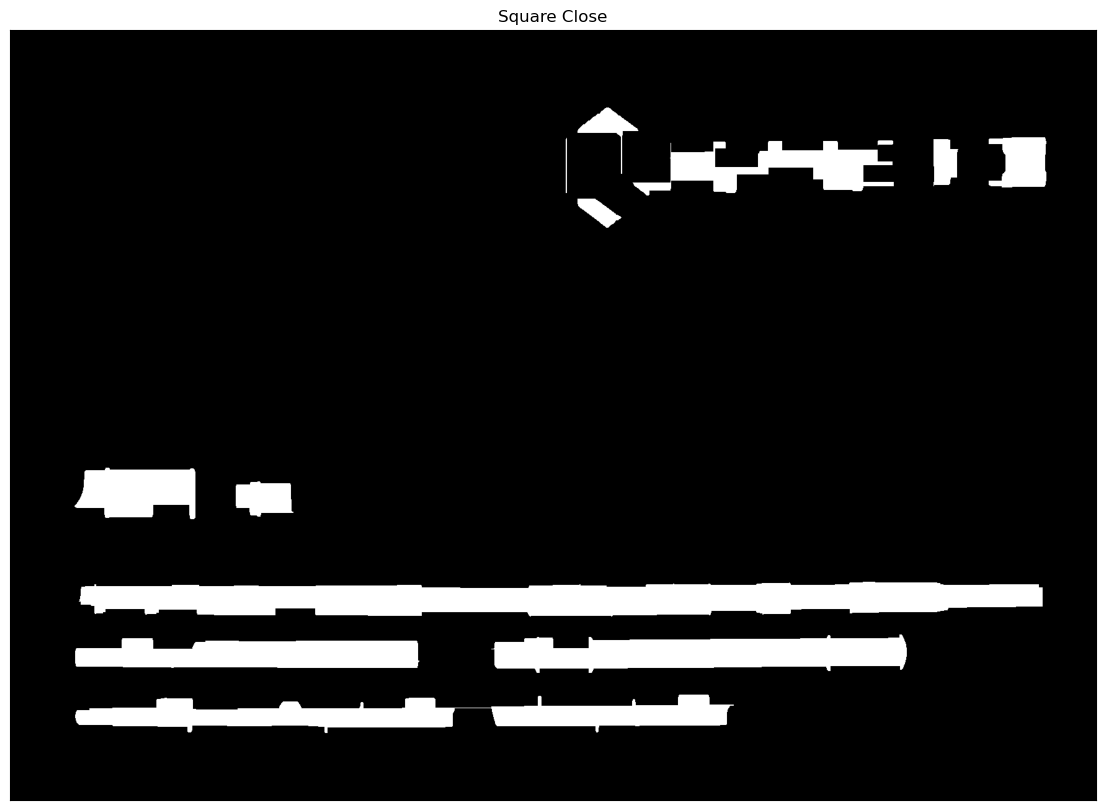

In [8]:
plt_imshow(["Square Close"], [close_thresh], figsize=(16, 10))

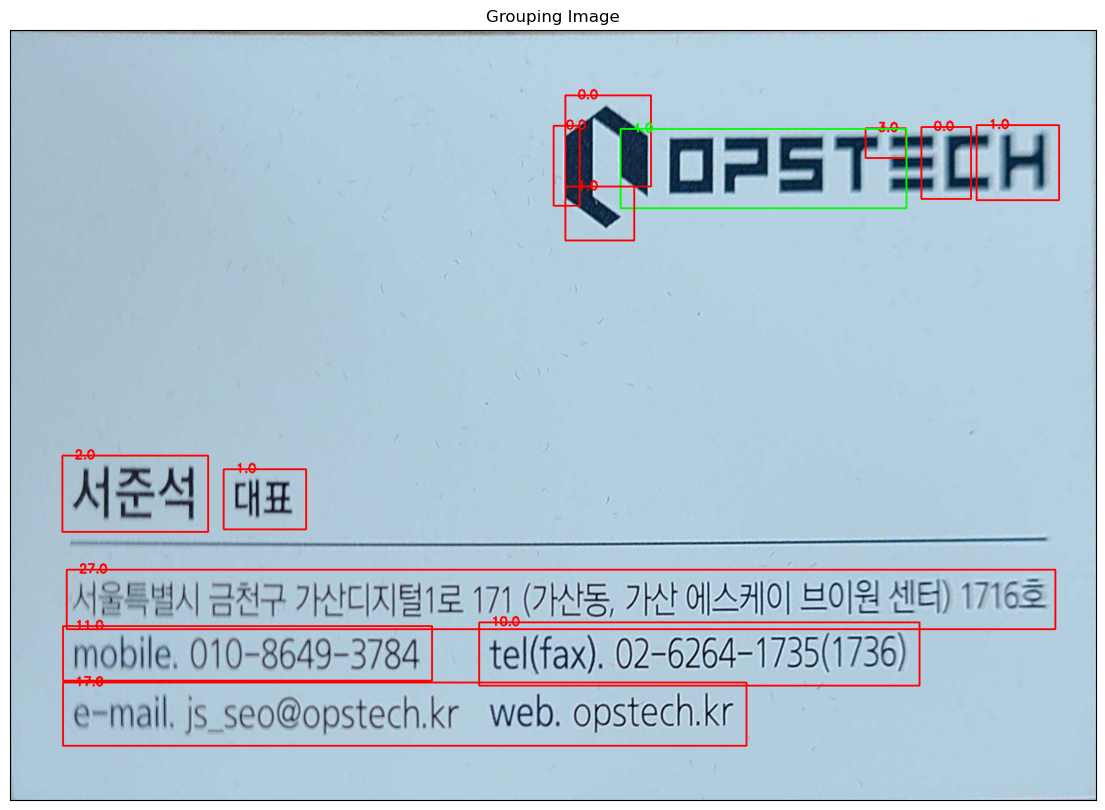

In [9]:
cnts = cv2.findContours(close_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="top-to-bottom")[0]
 
roi_list = []
roi_title_list = []
 
margin = 20
card_grouping = card_image.copy()
 
for c in cnts:
    (x, y, w, h) = cv2.boundingRect(c)
    ar = w // float(h)
 
    if ar > 3.0 and ar < 6.5 and (W/2) < x:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
        roi = card_image[y - margin:y + h + margin, x - margin:x + w + margin]
        roi_list.append(roi)
        roi_title_list.append("Roi_{}".format(len(roi_list)))
 
    cv2.rectangle(card_grouping, (x - margin, y - margin), (x + w + margin, y + h + margin), color, 2)
    cv2.putText(card_grouping, "".join(str(ar)), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, color, 2)
  
plt_imshow(["Grouping Image"], [card_grouping], figsize=(16, 10))

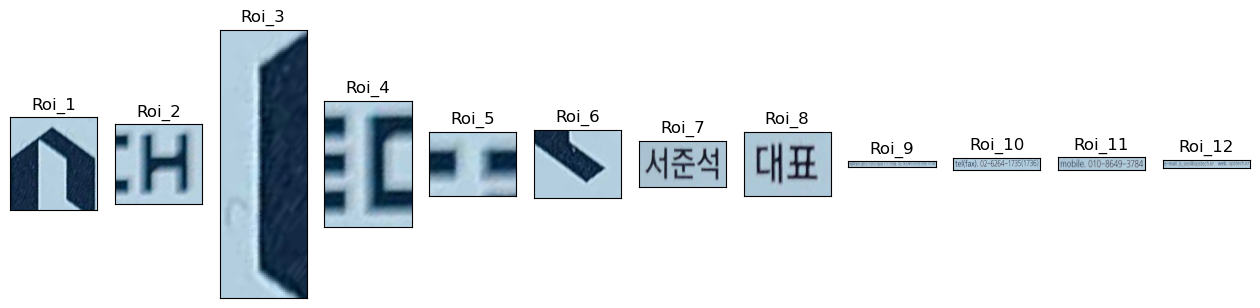

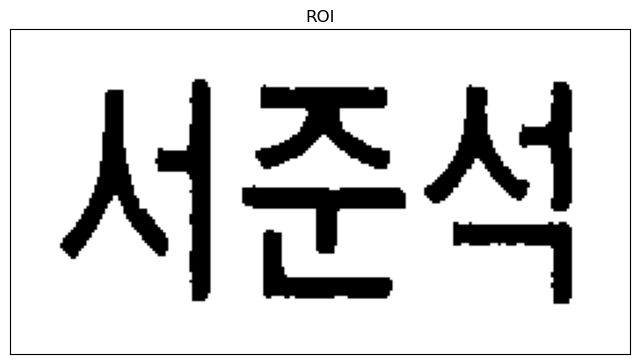

[INFO] OCR결과:
서준석





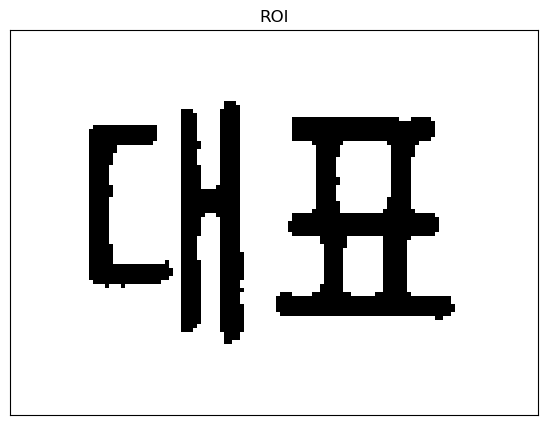

[INFO] OCR결과:
대표





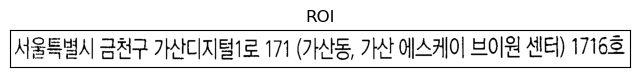

[INFO] OCR결과:
서울특별시 금천구 가산디지털1로 171 (가산동, 가산 에스케이 브이원 센터) 1716흐





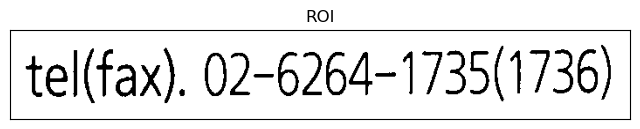

[INFO] OCR결과:
tel(fax). 02-6264-1735(1736)





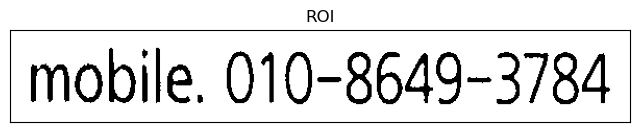

[INFO] OCR결과:
mobile. 010-8649-3784





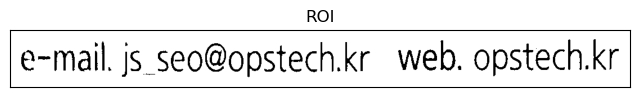

[INFO] OCR결과:
e-mail. js Seo@opstech.kr_ web. opstech.kr





In [10]:
plt_imshow(roi_title_list, roi_list, figsize=(16, 10))
text_list = []
 
for i in range(len(roi_list)):
    if i > 5:
        roi = roi_list[i]
        roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        roi = cv2.threshold(roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
        
        # 글씨 굵기를 조절하기 위한 커널 생성
        kernel = np.ones((2, 2), np.uint8)
        roi = cv2.erode(roi, kernel, iterations=1)
        roi = cv2.dilate(roi, kernel, iterations=1)
    
        plt_imshow("ROI", roi)
    
        text = pytesseract.image_to_string(roi, config=options, lang='kor+eng')
        text_list.append(text)
    
        print("[INFO] OCR결과:")
        print("==================")
        print(text)
        print("\n")